In [1]:
from atlite.datasets.era5 import retrieve_data, _rename_and_clean_coords, retrieval_times, _area
import xarray as xr
import atlite
import logging
import cdsapi
from cartopy.io import shapereader
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
logging.basicConfig(level=logging.INFO)

In [2]:
def natural_earth_shapes_EU(join_dict, drop_non_Europe=['MA','DZ','TN','GI']):
    # Download shape file (high resolution)
    shpfilename = shapereader.natural_earth(resolution='10m',
                                          category='cultural',
                                          name='admin_1_states_provinces')

    
    df =gpd.read_file(shpfilename)
    df = df.cx[-13:32,35:80]
    df = df[['iso_a2','geometry']]
    df = df.dissolve('iso_a2')
    df.index = list(df.index)
    drop_regions = drop_non_Europe
    # Absorbe microstates
    for main_r,sub_rs in join_dict.items():
        temp_main = df.loc[main_r,'geometry']
        for sub_r in sub_rs:
            drop_regions.append(sub_r)
            temp_r = df.loc[sub_r,'geometry']
        
            temp_main = temp_main.union(temp_r)
        temp_main = gpd.GeoSeries([temp_main])
        df.loc[[main_r],'geometry'] = temp_main.values
    
    df = df.drop(index=drop_regions)
    return df


Create Europe shapefile

In [3]:

join_dict = {'FR':['GG','AD','MC'],'IT':['VA','SM'], 'GB':['JE','IM'],'FI':['AX'],'DK':['FO'],
            'CH':['LI'], 'BE':['LU'],'RS':['XK']}
europe = natural_earth_shapes_EU(join_dict)


## CMIP Solar capacites

In [2]:
esgf_params = {
   'data_node': 'esgf-cnr.hpc.cineca.it',
   'source_id': 'EC-Earth3',
   'variant_label':'r4i1p1f1',
   'experiment_id': 'ssp126',
   'project' : 'CMIP6',
   'frequency':'3hr'
}

cutout_cmip = atlite.Cutout(path='cmip_europe.nc',module=['cmip'],
                      x=slice(-13,45),
                      y=slice(32,83),
                           time='2021-01',
                           esgf_params=esgf_params,
                           dt='3H',dx=1, dy=1)

In [3]:
cutout_cmip.prepare()

Python 3.8.10 | packaged by conda-forge | (default, May 11 2021, 07:01:05) 
Type 'copyright', 'credits' or 'license' for more information
IPython 7.25.0 -- An enhanced Interactive Python. Type '?' for help.

Out[1]: 
[Delayed('get_data-73bbfd02-d114-4cfa-95fb-c65f88da4ba7'),
 Delayed('get_data-7b05ec5f-c770-4a59-a6c4-e8531d79a371'),
 Delayed('get_data-d93baf5c-a436-4a99-b9d4-db28cd4d0635'),
 Delayed('get_data-6ce844cf-ff14-4745-8594-9e7d6e3cf9ba')]





---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
~/atlite/atlite/data.py in <module>
----> 1 datasets = compute(*datasets)

~/miniconda3/envs/atlite_dev/lib/python3.8/site-packages/dask/base.py in compute(*args, **kwargs)
    563         postcomputes.append(x.__dask_postcompute__())
    564 
--> 565     results = schedule(dsk, keys, **kwargs)
    566     return repack([f(r, *a) for r, (f, a) in zip(results, postcomputes)])
    567 

~/

KeyError: "not all values found in index 'time'"

In [6]:
cutout_cmip.data

<xarray.Dataset>
Dimensions:      (time: 248, x: 59, y: 52)
Coordinates:
  * x            (x) int64 -13 -12 -11 -10 -9 -8 -7 -6 ... 39 40 41 42 43 44 45
  * y            (y) int64 32 33 34 35 36 37 38 39 ... 76 77 78 79 80 81 82 83
  * time         (time) datetime64[ns] 2021-01-01 ... 2021-01-31T21:00:00
    lon          (x) float64 dask.array<chunksize=(59,), meta=np.ndarray>
    lat          (y) float64 dask.array<chunksize=(52,), meta=np.ndarray>
Data variables:
    wnd10m       (time, y, x) float32 dask.array<chunksize=(100, 52, 59), meta=np.ndarray>
    influx       (time, y, x) float32 dask.array<chunksize=(100, 52, 59), meta=np.ndarray>
    outflux      (time, y, x) float32 dask.array<chunksize=(100, 52, 59), meta=np.ndarray>
    temperature  (time, y, x) float32 dask.array<chunksize=(100, 52, 59), meta=np.ndarray>
    runoff       (time, y, x) float32 dask.array<chunksize=(100, 52, 59), meta=np.ndarray>
Attributes: (12/56)
    module:                          cmip
    prepared_features:               ['runoff', 'temperature', 'wind', 'influx']
    chunksize_time:                  100
    model:                           EC-Earth3
    dt:                              3H
    dx:                              1
    ...                              ...
    tracking_id:                     hdl:21.14100/c38fc6f8-7b95-4a22-a21d-a01...
    history:                         2019-08-05T08:01:37Z ; CMOR rewrote data...
    DODS_EXTRA.Unlimited_Dimension:  time
    data_node:                       esgf-cnr.hpc.cineca.it
    project:                         CMIP6
    variable:                        sfcWind

In [7]:
pv_cp = cutout_cmip.pv('CSi',shapes=europe,orientation='latitude_optimal', capacity_factor=True, per_unit=True)

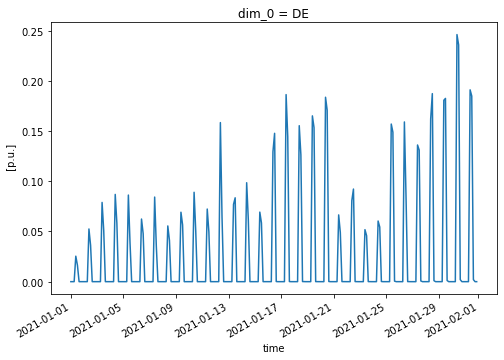

In [8]:
fig,ax = plt.subplots(figsize=(8,5))
pv_cp.sel(dim_0='DE').plot()


Text(0.5, 1.0, '1 Jaunary Mean PV Solar EC-Earth3')

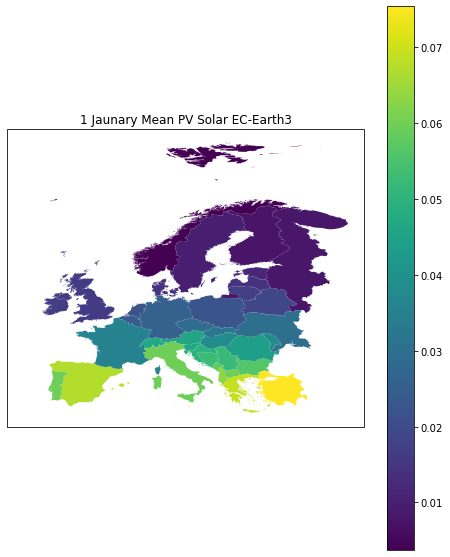

In [9]:
fig,ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()),figsize=(8,10))
europe['mean_cf_pv'] = pv_cp.mean(dim='time')
europe.plot(column='mean_cf_pv', ax=ax, legend=True)
ax.set_title('1 Jaunary Mean PV Solar EC-Earth3')

## Wind Capacity factor CMIP

The surface roughness is not available from the CMIP database so ERA5 roughness is used instead.|

In [10]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels-monthly-means',
    {
        'format': 'netcdf',
        'product_type': 'monthly_averaged_reanalysis',
        'variable': 'forecast_surface_roughness',
        'year': '2019',
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'area': [
            83, -13, 32,
            45,
        ],
        'time': '00:00',
    },
    'roughness.nc')

Result(content_length=1149236,content_type=application/x-netcdf,location=https://download-0013.copernicus-climate.eu/cache-compute-0013/cache/data2/adaptor.mars.internal-1624960156.6650481-4977-12-177b4b20-717b-4d6d-b681-d6f1395d71cc.nc)

In [11]:
from atlite.datasets.era5 import _rename_and_clean_coords

Create roughness data based on 1 year average from ERA5. Then interpolate the ERA5 data into the resolution of CMIP.

In [12]:
roughness = xr.open_dataset('roughness.nc')

roughness = roughness.rename({'fsr':'roughness'})

roughness = roughness.mean(dim='time')

roughness = _rename_and_clean_coords(roughness)
roughness.roughness.attrs['prepared_feature'] = 'wind'

da = roughness.roughness.interp_like(cutout_cmip.data['influx'].isel(time=0))

cutout_cmip.data = cutout_cmip.data.assign(roughness=da)

In [13]:
cp_wind = cutout_cmip.wind('Vestas_V112_3MW', shapes=europe,capacity_factor=True, per_unit=True)

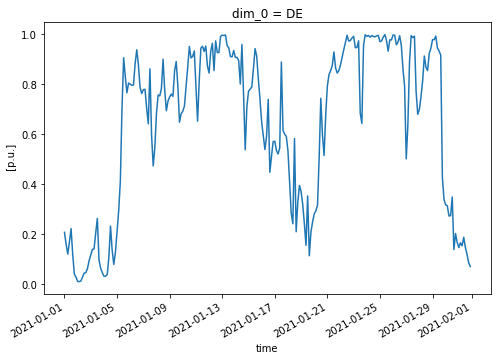

In [14]:
fig,ax = plt.subplots(figsize=(8,5))
cp_wind.sel(dim_0='DE').plot()

Text(0.5, 1.0, 'Single Jaunary Mean wind capacites EC-Earth3')

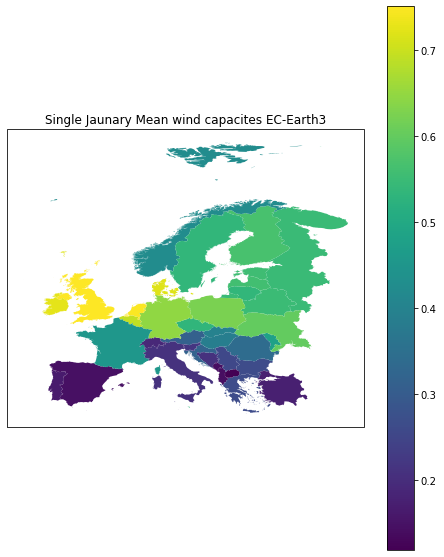

In [15]:
fig,ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()),figsize=(8,10))
europe['mean_cp_wind'] = cp_wind.mean(dim='time')
europe.plot(column='mean_cp_wind', ax=ax, legend=True)
ax.set_title('Single Jaunary Mean wind capacites EC-Earth3')